## Sea Performance Model

The performace of the system as a whole can be broken down into three components: 1) The amount of time it takes
to read the data from Lustre, 2) the amount of time it takes to read and write the required data to memory, and 3) the amount of time it takes to read and write the data to disk. 

First, we shall devise a simplified performance model for Lustre alone, as this will give us an upper bound to the 
added performance of Sea. We describe Lustre's performance as follows:

$$ M_{l} =  \frac{D_{in}I}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lr}\min{(O, nN_{c}}))}} + \frac{D_{in}I}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lw}\min{(O, nN_{c}}))}}$$

$\text{Where,}$<br>
$M_{l}$ represents Lustres makespan<br>
$D_{in}$ is the size of the input dataset<br>
$I$ is the total number of iterations<br>
$O$ is the number of Lustre OSTs<br>
$N_{c}$ is the number of compute nodes<br>
$N_{d}$ is the number of data nodes<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>
$B_{lw}$ is a Lustre OST's write bandwidth<br>

Essentially, the makespan can be descriped as the total time it takes to read and write all the data to and from Lustre. Lustre can have a bottleneck in one of two places: within the network transfer, due to limited network bandwidth, or the OSTs, due to collective disk bandwidths. It is important to account for both of these bottlenecks as they may fluctuate depending on the number of compute nodes required for a given experiment.


### The Linux Page Cache Model


The aforementioned models are imperfect in that they describe a scenario in which data outside of Sea is not cached in memory. This is an unlikely case as many systems leverage, by default, the page cache in order speed up I/O to non-volatile storage media.

Due to the difficulties associated with designing a model that accurately captures all page cache
intricacies, we will design our model to define the upper and lower performance bounds. As such,
we define the data read from page cache as:

$$D_{cr} = D_{in}(I-1)$$

Where,<br>
$D_{in}$ is the input dataset size<br>
$I$ is the number of iterations<br>

In other words, all the data with the exception of the initial read is read from page cache.

Unlike the reads, even the initial write can be stored in page cache, therefore we define the data that
fits in cache as:
$$D_{cw} = D_{in}I$$

Where,<br>
$D_{in}$ is the input dataset size<br>
$I$ is the number of iterations<br>


The page cache model can be described as follows:

$$M_{pc} = \frac{D_{cr}}{B_{mr}N_{c}} + \frac{D_{cw}}{B_{mw}N_{c}}$$

Where,<br>
$M_{pc}$ is the makespan of reading and writing to page cache<br>
$D_{cr}$ is the amount of data read from page cache<br>
$D_{cw}$ is the amount of data written with memory bandwidth<br>
$N_{c}$ is the number of compute nodes<br>
$B_{mr}$ is the bandwidth of a memory read<br>
$B_{mw}$ is the bandwidth of a memory write<br>


Therefore, the Lustre makespan model can be rewritten as:

$$M_{l} =  \underbrace{\frac{D_{in}}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lr}O)}}}_\text{Lustre initial read} + M_{pc}$$

Where,<br>
$M_{l}$ represents Lustres makespan<br>
$M_{pc}$ is the makespan of reading and writing to page cache<br>
$D_{in}$ is the size of the input dataset<br>
$O$ is the number of Lustre OSTs<br>
$N_c$ is the number of compute nodes<br>
$N_d$ is the number of data nodes<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>


### Sea model

Sea's makespan is similar to that of Lustre's page cache except that at its lower bound, memory is
limited and thus some writes must occur on less performant storage devices. Sea's makespan can therefore be written as:

$$M_{s} = M_{sl} + M_{sd} + M_{st} $$

where,<br>
$M_{s}$ is the makespan of an data-intensive application executing with Sea <br>
$M_{sl}$ is the makespan of the Lustre component of Sea <br>
$M_{sd}$ is the makespan of the disk component of Sea <br>
$M_{st}$ is the makespan of the tmpfs component of Sea<br>

The tmpfs component of Sea can be define as the time
it takes to read and write the data to tmpfs.

$$ M_{st} = \frac{D_{tr}}{B_{mr}N_{c}} + \frac{D_{tw}}{B_{mw}N_{c}} $$

$$ D_{tr} = \min(D_{m}, \max(N_{c}(S_{t}-FN_{t}), 0)) $$
$$ D_{tw} = \min(D_{m} + D_{f}, \max(N_{c}(S_{t} - FN_{t}, 0)) $$

Where,
$S_{t}$ is the available storage space on tmpfs<br>
$N_{t}$ is the number of available threads per node<br>
$D_{m}$ is the intermediate data produced by the application<br>
$D_{f}$ is the final output data<br>


Similarly to the tmpfs component is the disk component:
$$ M_{sd} = \frac{D_{dr}}{B_{dr}\min(n, d)N_{c}} + \frac{D_{dw}}{B_{dw}\min(n,d)N_{c}} $$

$$ D_{dr} = \min(D_{m} - D_{tr}, \max(N_{c}(S_{d}d-FN_{t}), 0)) $$
$$ D_{dw} = \min(D_{m} + D_{f} - D_{tw}, \max(N_{c}(S_{d}d - FN_{t}), 0)) $$

Finally, the Lustre component of Sea is:

$$M_{sl} + \frac{D_{I}}{B_{lr}} + \frac{D_{lr}}{B_{lr}} + \frac{D_{lw}}{B_{lw}}$$

$$D_{lr} = D_{m} - D_{dr} - D_{tr}$$
$$D_{lw} = D_{m} + D_{f} - D_{dw} - D_{tw}$$


In [27]:
# lustre redone
from math import ceil
lustre_rbw = lambda B_n, N_c, N_d, B_lr, O, n : min(B_n * N_c, B_n * N_d, (B_lr * min(O, n*N_c)))#min(O/ceil(n/O), n * N_c)))#(n * N_c))
lustre_wbw = lambda B_n, N_c, N_d, B_lw, O, n : min(B_n * N_c, B_n * N_d, (B_lw * min(O, n*N_c)))#min(O/ceil(n/O), n * N_c)))#(n * N_c))

M_l = (lambda
       D_in,
       I,
       O,
       n,
       N_c,
       N_d,
       B_n,
       B_lr,
       B_lw : ((D_in * I)/ lustre_rbw(B_n, N_c, N_d, B_lr, O, n)) 
       + ((D_in * I)/ lustre_wbw(B_n, N_c, N_d, B_lw, O, n))
)

D_cr = (lambda
        D_in,
        N_c,
        N_d,
        I,
        A,
        F,
        n : D_in*(I-1)#min((A - ((F * n)/2))*(1000/n), D_in)*(I-1)
       )

D_cw = (lambda
        D_in,
        N_c,
        N_d,
        I,
        C,
        A,
        F,
        n,
        Bn,
        B_lw,
        B_mw: D_in*I)#min(N_c * C * (A - ((F * n)/2)), 500*n*N_c, D_in)*I +
        #((min(N_c * C * (A - ((F * n)/2)), 500*n*N_c, D_in)*I)/ (B_mw * N_c))*lustre_wbw(B_n, N_c, N_d, B_lw, O, n)
        #)

M_pc = (lambda
        D_in,
        N_c,
        N_d,
        I,
        C,
        A,
        F,
        n,
        B_mr,
        B_mw, 
        B_n,
        B_lw: (D_cr(D_in, N_c, N_d, I, A, F, n) / (B_mr * N_c)) +
        (D_cw(D_in, N_c, N_d, I, C, A, F, n, B_n, B_lw, B_mw)/ (B_mw * N_c))
        )

M_rpc = (lambda
         D_in,
         N_c,
         N_d,
         I,
         A,
         F,
         n,
         B_mr: (D_cr(D_in, N_c, N_d, I, A, F, n) / (B_mr * N_c)))

M_wpc = (lambda
         D_in,
         N_c,
         N_d,
         I,
         C,
         A,
         F,
         n,
         B_mw,
         B_n,
         B_lw: (D_cw(D_in, N_c, N_d, I, C, A, F, n)/ (B_mw * N_c)) +
         ((D_cw(D_in, N_c, N_d, I, C, A, F, n,B_n, B_lw, B_mw)/ (B_mw * N_c))*lustre_wbw(B_n, N_c, N_d, B_lw, O, n))
         )

M_lpc = (lambda
         D_in,
         N_c,
         N_d,
         I,
         C,
         A,
         F,
         n,
         O,
         B_n,
         B_lr,
         B_lw,
         B_mr,
         B_mw:
         (D_in / min(B_n * N_c, B_n * N_d, B_lr * min(O/ceil(n/O), n*N_c)))
         + M_pc(D_in, N_c, N_d, I, C, A, F, n, B_mr, B_mw, B_n, B_lw))
         #+ (((D_in * (I - 1)) - D_cr(D_in, N_c, N_d, I, A, F, n))/ lustre_rbw(B_n, N_c, N_d, B_lr, O, n))
         #+ (((D_in * I) - D_cw(D_in, N_c, N_d, I, C, A, F, n, B_n, B_lw, B_mw)) / lustre_wbw(B_n, N_c, N_d, B_lw, O, n)))


In [28]:
# Sea models redone

D_tw = (lambda
        D_in,
        I,
        S_t,
        F,
        n,
        N_c : min(D_in*I, max(S_t - (F*n), 0)*N_c))

D_tr = (lambda
        D_in,
        I,
        S_t,
        F,
        n,
        N_c: min(D_in*(I - 1), max(S_t - (F*n), 0)*N_c))

M_st = (lambda 
        D_in,
        I,
        S_t,
        F,
        n,
        N_c,
        B_mr,
        B_mw : (D_tr(D_in, I, S_t, F, n, N_c) / (B_mr * N_c)) + 
        (D_tw(D_in, I, S_t, F, n, N_c) / (B_mw * N_c)))

D_dw = (lambda
        D_in,
        I,
        S_t,
        F,
        n,
        S_d,
        d,
        N_c : min((D_in*I) - D_tw(D_in, I, S_t, F, n, N_c),
                 max((S_d*d) - (F*n), 0)*N_c))
D_dr = (lambda
        D_in,
        I,
        S_t,
        F,
        n,
        N_c,
        S_d,
        d : min((D_in*(I-1)) - D_tr(D_in, I, S_t, F, n, N_c),
                max((S_d*d) - (F*n), 0)*N_c))

M_sd = (lambda
        D_in,
        I,
        S_t,
        F,
        n,
        N_c,
        S_d,
        d,
        B_dr,
        B_dw: 
        (D_dr(D_in, I, S_t, F, n, N_c, S_d, d) / (B_dr * min(n,d) * N_c)) +
        (D_dw(D_in, I, S_t, F, n, N_c, S_d, d) / (B_dw * min(n, d) * N_c)))

M_sl = (lambda
        D_in,
        B_n,
        N_c,
        N_d,
        B_lr,
        B_lw,
        O,
        n,
        I,
        S_t,
        F,
        S_d,
        d: 
        D_in / lustre_rbw(B_n, N_c, N_d, B_lr, O, n) +
        (max((D_in*(I-1)) - D_dr(D_in, I, S_t, F, n, N_c, S_d, d) - D_tr(D_in, I, S_t, F, n, N_c) ,0) / lustre_rbw(B_n, N_c, N_d, B_lr, O, n)) +
        (max((D_in*I) - D_dw(D_in, I, S_t, F, n, N_c, S_d, d) - D_tw(D_in, I, S_t, F, n, N_c), 0) / lustre_wbw(B_n, N_c, N_d, B_lw, O, n)))

M_s = (lambda
       D_in,
       I,
       S_t,
       F,
       n,
       N_c,
       S_d,
       d,
       B_n,
       B_lr,
       B_lw,
       N_d,
       O,
       B_mr,
       B_mw,
       B_dr,
       B_dw :
       M_sl(D_in, B_n, N_c, N_d, B_lr, B_lw, O, n, I, S_t, F, S_d, d) +
       M_st(D_in, I, S_t, F, n, N_c, B_mr, B_mw) +
       M_sd(D_in, I, S_t, F, n, N_c, S_d, d, B_dr, B_dw))

       



### Model evaluation - Network bandwidth

(0.0, 103.9)

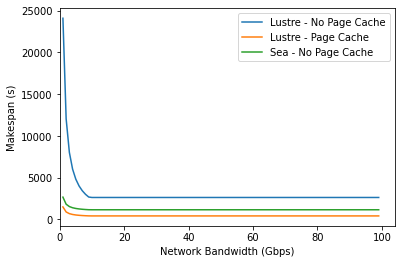

In [29]:
bw = range(128, 100*128, 128)
gbps = [b/128 for b in bw]

F = 617
n_f = 999 #1000
D_in = F * n_f
N_c = 4
N_d = 4
d = 6
I = 10
C = 0.40
A = 200 * 1024
n = 6
O = 44
B_n = 25 * 128
B_lr = 200
B_lw = 191
B_mr = 6676.48 #6760 * 7
B_mw = 2560 * 7
B_dr = 500
B_dw = 426
S_t = 126 * 1024
S_d = 447 * 1024

lustre_npc = [M_l(D_in, I, O, n, N_c, N_d, b, B_lr, B_lw) for b in bw]
lustre_pc = [M_lpc(D_in, N_c, N_d, I, C, A, F, n, O, b, B_lr, B_lw, B_mr, B_mw) for b in bw]
sea_npc = [M_s(D_in, I, S_t, F, n, N_c, S_d, d, b, B_lr, B_lw, N_d, O, B_mr, B_mw, B_dr, B_dw) for b in bw]

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=gbps, y=lustre_npc, label="Lustre - No Page Cache")
sns.lineplot(x=gbps, y=lustre_pc, label="Lustre - Page Cache")
sns.lineplot(x=gbps, y=sea_npc, label="Sea - No Page Cache")
plt.xlabel("Network Bandwidth (Gbps)")
plt.ylabel("Makespan (s)")
plt.xlim(0)

### Model evaluation - Number of nodes

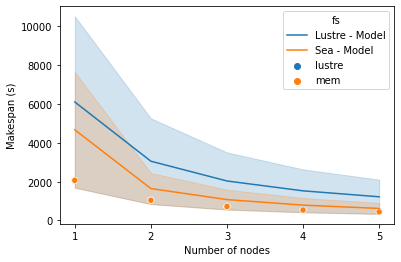

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bw = range(128, 100*128, 128)
gbps = [b/128 for b in bw]

F = 617
n_f = 1000
D_in = F * n_f
N_c = 4
N_d = 4
d = 6
I = 10
C = 0.40
A = 200 * 1024
n = 6
O = 44
B_n = 25 * 128
B_lr = 200
B_lw = 191
B_mr = 6676.48 #6760 * 7
B_mw = 2560 * 7
B_dr = 500
B_dw = 426
S_t = 126 * 1024
S_d = 447 * 1024

nodes = list(range(1,6))
lustre_npc = [M_l(D_in, I, O, n, nc, N_d, B_n, B_lr, B_lw) for nc in nodes]
lustre_pc = [M_lpc(D_in, nc, N_d, I, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for nc in nodes]
sea_npc = [M_s(D_in, I, S_t, F, n, nc, S_d, d, B_n, B_lr, B_lw, N_d, O, B_mr, B_mw, B_dr, B_dw) for nc in nodes]

df_lustre = pd.read_csv("../results/exp_nodes.out")#_lustre.out")
df_lustre["nodes"] = df_lustre["experiment"].apply(lambda row: int(row.split('n_')[0].split("_")[-1]))
df_lustre["fs"] = df_lustre["experiment"].apply((lambda row: row.split("_")[0] if "lustre" in row else row.split("_")[1]))
df_lustre = df_lustre.sort_values(by=["fs", "nodes"])


sns.lineplot(x=nodes+nodes, y=lustre_pc + lustre_npc, label="Lustre - Model")
sns.lineplot(x=nodes+nodes, y=lustre_pc + sea_npc, label="Sea - Model")
sns.scatterplot(data=df_lustre, x="nodes", y="runtime", hue="fs")
plt.xlabel("Number of nodes")
plt.ylabel("Makespan (s)")
plt.xticks(nodes)
plt.savefig("/home/valeriehayot/Documents/code/gradseminar/figures/nodes.svg")
plt.show()


### Model evaluation - Number of disks

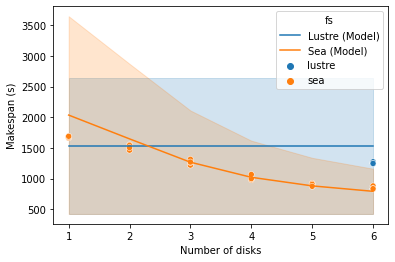

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = 4
disks = list(range(1, 7))

lustre_npc = [M_l(D_in, I, O, n, nodes, N_d, B_n, B_lr, B_lw) for d in disks]
lustre = [M_lpc(D_in, nodes, N_d, I, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for d in disks]
sea_npc = [M_s(D_in, I, S_t, F, n, nodes, S_d, di, B_n, B_lr, B_lw, N_d, O, B_mr, B_mw, B_dr, B_dw) for di in disks]

df_l = pd.read_csv("../results/exp_disk.out")
df_l["disks"] = df_l["experiment"].apply(lambda name: int(name.split("d_")[0].split("_")[-1]))
df_l["fs"] = df_l["experiment"].apply(lambda name: name.split("_")[0])
df_l = df_l.sort_values(by=['fs','disks'])

sns.lineplot(x=disks + disks, y=lustre_npc + lustre, label="Lustre (Model)")
sns.lineplot(x=disks+disks, y=sea_npc + lustre, label="Sea (Model)")
sns.scatterplot(data=df_l, x="disks", y="runtime", hue="fs")
plt.xlabel("Number of disks")
plt.ylabel("Makespan (s)")
plt.xticks(disks)
plt.savefig("/home/valeriehayot/Documents/code/gradseminar/figures/disks.svg")
plt.show()
#df_l

### Model evaluation - Number of iterations (NEEDS TO BE REDONE)

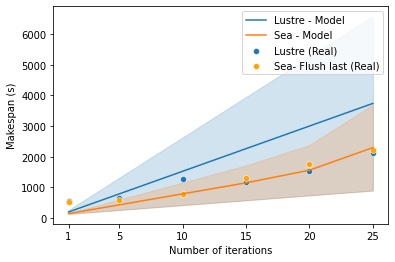

,experiment,repetition,runtime_x,flush_time,disk_files,total_flush,iterations,runtime_y,speedup
0,mem,0,1317.292153,0m30.294s real 0m25.364s real 0m32.285s real 0...,950,1000,15,1174.134210,0.891324
1,mem,0,774.780795,0m22.807s real 0m16.515s real 0m15.822s real 0...,917,1000,10,1284.631077,1.658057
2,mem,0,1750.507790,0m33.408s real 0m33.520s,871,902,20,1536.485978,0.877737
3,mem,0,512.480171,0m4.483s real 0m4.869s real 0m2.879s real 0m3....,0,1000,1,548.242647,1.069783
4,mem,0,2219.031397,0m33.584s real 0m33.418s real 0m33.844s,687,711,25,2127.722456,0.958852
5,mem,0,577.712885,0m9.321s real 0m10.608s real 0m9.745s real 0m1...,803,1000,5,667.814086,1.155962


In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

d = 6
n_iterations = [1, 5, 10, 15, 20, 25]

lustre = [M_lpc(D_in, N_c, N_d, i, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for i in n_iterations]
lustre_npc = [M_l(D_in, i, O, n, N_c, N_d, B_n, B_lr, B_lw) for i in n_iterations]
sea_npc = [M_s(D_in, i, S_t, F, n, N_c, S_d, d, B_n, B_lr, B_lw, N_d, O, B_mr, B_mw, B_dr, B_dw) for i in n_iterations]

df_lustre = pd.read_csv("../results/exp_iterations_lustre.out")
df_lustre["iterations"] = df_lustre["experiment"].apply(lambda row: int(row.split("_")[-1].strip("i")))
df_lustre["experiment"] = df_lustre["experiment"].apply((lambda row: row.split("_")[0] if "lustre" in row else row.split("_")[1]))

df_mem = pd.read_csv("../results/exp_iterations_sea.out")
df_mem["iterations"] = df_mem["experiment"].apply(lambda row: int(row.split("_")[-1].strip("i")))
df_mem["experiment"] = df_mem["experiment"].apply((lambda row: row.split("_")[0] if "lustre" in row else row.split("_")[1]))

its = n_iterations + n_iterations
sns.lineplot(x=its, y=lustre+lustre_npc, label="Lustre - Model")
sns.lineplot(x=its, y=lustre+sea_npc, label="Sea - Model")
sns.scatterplot(data=df_lustre, x="iterations", y="runtime", label="Lustre (Real)")
sns.scatterplot(data=df_mem, x="iterations", y="runtime", label="Sea- Flush last (Real)", color="orange")
#sns.lineplot(x=n_iterations, y=lustre_npc, label="Lustre - Page Cache (Model)")
plt.xlabel("Number of iterations")
plt.ylabel("Makespan (s)")
plt.xticks(n_iterations)
plt.savefig("/home/valeriehayot/Documents/code/gradseminar/figures/iterations.svg")
plt.show()
df = pd.merge(df_mem, df_lustre.sort_values(["iterations"])[["iterations", "runtime"]], on="iterations")
df["speedup"] = df["runtime_y"] / df["runtime_x"]
df

### Model evaluation - Number of files (NEEDS TO BE REDONE)

(0.0, 25140.940096355946)

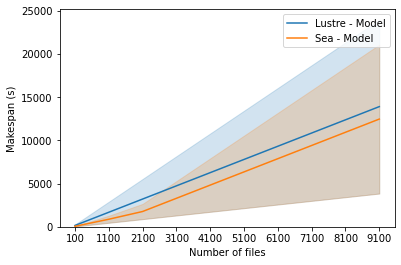

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

num_files = list(range(100, 10001, 1000))

lustre = [M_lpc(f*F, N_c, N_d, I, C, A, F, n, O, B_n, B_lr, B_lw, B_mr, B_mw) for f in num_files]
lustre_npc = [M_l(f*F, I, O, n, N_c, N_d, B_n, B_lr, B_lw) for f in num_files]
sea_npc = [M_s(f*F, I, S_t, F, n, N_c, S_d, d, B_n, B_lr, B_lw, N_d, O, B_mr, B_mw, B_dr, B_dw) for f in num_files]


sns.lineplot(x=num_files+num_files, y=lustre+lustre_npc, label="Lustre - Model")
sns.lineplot(x=num_files+num_files, y=lustre+sea_npc, label="Sea - Model")
#sns.lineplot(x=num_files, y=lustre_npc, label="Lustre - No Page Cache (Model)")
plt.xlabel("Number of files")
plt.ylabel("Makespan (s)")
plt.xticks(num_files)
plt.ylim(0)

### Model evaluation - Number of threads

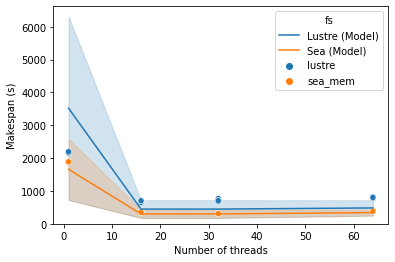

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

threads = [1, 16, 32, 64]

F = 617
n_f = 1000
D_in = F * n_f
N_c = 5
N_d = 4
d = 6
I = 5
C = 0.40
A = 200 * 1024
O = 44
B_n = 25 * 128
B_lr = 200
B_lw = 191
B_mr = 6676.48 #6760 * 7
B_mw = 2560 * 7
B_dr = 500
B_dw = 426
S_t = 126 * 1024
S_d = 447 * 1024


lustre = [M_lpc(D_in, N_c, N_d, I, C, A, F, t, O, B_n, B_lr, B_lw, B_mr, B_mw) for t in threads]
lustre_npc = [M_l(D_in, I, O, t, N_c, N_d, B_n, B_lr, B_lw) for t in threads]
sea_npc = [M_s(D_in, I, S_t, F, t, N_c, S_d, d, B_n, B_lr, B_lw, N_d, O, B_mr, B_mw, B_dr, B_dw) for t in threads]

df_lustre = pd.read_csv("../results/exp_threads.out")
df_lustre["fs"] = df_lustre["experiment"].apply(lambda x: "_".join(x.split("_")[0:2]) if "sea" in x else x.split("_")[0])
df_lustre = df_lustre[df_lustre["fs"] != "sea_cp"]
df_lustre["threads"] = df_lustre["experiment"].apply(lambda row: int(row.split("t_")[0].split("_")[-1]))
df_lustre = df_lustre.sort_values(by=["fs", "threads"])
df_lustre = df_lustre[df_lustre["repetition"] > 0]

sns.lineplot(x=threads+threads, y=lustre + lustre_npc, label="Lustre (Model)")
sns.lineplot(x=threads+threads, y=lustre + sea_npc, label="Sea (Model)")
sns.scatterplot(data=df_lustre, x="threads", y="runtime", hue="fs")

plt.xlabel("Number of threads")
plt.ylabel("Makespan (s)")
plt.ylim(0)
plt.savefig("/home/valeriehayot/Documents/code/gradseminar/figures/threads.svg")
plt.show()
#df = pd.merge(df_mem, df_lustre.sort_values(["threads"])[["threads", "runtime"]], on="threads")
#df["speedup"] = df["runtime_y"] / df["runtime_x"]

## Read only experiments - 1 iteration

$$ M_{l} =  \frac{D_{in}I}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lr}\min{(O, nN_{c}}))}} + \frac{D_{in}I}{\min{(B_{n}N_{c}, B_{n}N_{d}, B_{lw}\min{(O, nN_{c}}))}}$$

$\text{Where,}$<br>
$M_{l}$ represents Lustres makespan<br>
$D_{in}$ is the size of the input dataset<br>
$I$ is the total number of iterations<br>
$O$ is the number of Lustre OSTs<br>
$N_{c}$ is the number of compute nodes<br>
$N_{d}$ is the number of data nodes<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>
$B_{lw}$ is a Lustre OST's write bandwidth<br>

## Gantts for Sea node experiments

In [16]:
import figures as fg
data = "../results/exp_nodes/run-0/lustre_1n_6t_6d_1000f_617m_10i/benchmarks.out"
df = fg.load_df(data)
print(df.groupby("action")["duration"].mean())
fg.bokeh_gantt(df)

action
increment     0.000
read         11.599
write         0.689
Name: duration, dtype: float64


Loading BokehJS ...

In [17]:
import figures as fg
data = "../results/exp_nodes/run-0/sea_mem_1n_6t_6d_1000f_617m_10i/benchmarks.out"
df = fg.load_df(data)
print(df.groupby("action")["duration"].mean())
fg.bokeh_gantt(df)

action
increment     0.000
read         11.402
write         0.892
Name: duration, dtype: float64


Loading BokehJS ...

In [18]:
import figures as fg
data = "../results/exp_nodes/run-0/sea_mem_5n_6t_6d_1000f_617m_10i/benchmarks.out"
df = fg.load_df(data)
print(df.groupby("action")["duration"].mean())
fg.bokeh_gantt(df)

action
increment    0.000
read         8.465
write        1.067
Name: duration, dtype: float64


Loading BokehJS ...

In [39]:
import figures as fg
data = "../results/exp_nodes/run-0/lustre_5n_6t_6d_1000f_617m_10i/benchmarks.out"
df = fg.load_df(data)
print(df.groupby("action")["duration"].mean())
fg.bokeh_gantt(df)

action
increment    0.000
read         9.201
write        0.994
Name: duration, dtype: float64


Loading BokehJS ...